In [18]:
import numpy as np
import os
import matplotlib.pyplot as plt
import glob # list files in a directory

In [23]:
import math
from numpy import linalg as LA
import gzip
import pandas as pd
import pdb
import random
from random import randint
import scipy.io
import sklearn
from operator import itemgetter
from heapq import nlargest
from scipy.spatial.distance import pdist, squareform

In [24]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.4.
The scikit-learn version is 0.20.3.


In [28]:
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import f1_score

In [30]:
from deap import algorithms
from deap import base
from deap import creator
from deap import tools

In [31]:
from keras.models import Sequential
from keras.layers.core import Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils, generic_utils
from keras.optimizers import SGD, RMSprop, Adadelta, Adagrad, Adam
from keras.layers import normalization
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras import regularizers
from keras.constraints import maxnorm
from keras.layers import  normalization
from keras import regularizers
from keras.layers import merge
from keras.constraints import maxnorm
from keras.layers import Input,Dense,Add
from keras.layers.merge import concatenate
from keras import optimizers

Using TensorFlow backend.


In [32]:
# import configurations (file paths, etc.)
import yaml
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper
    
configFile = '../cluster/data/medinfmk/ddi/config/config.yml'

with open(configFile, 'r') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=Loader)
    
#print(cfg)

In [86]:
pathInput = cfg['filePaths']['dirRaw']
pathOutput = cfg['filePaths']['dirProcessed']
# path to store python binary files (pickles)
# in order not to recalculate them every time
pathPickles = cfg['filePaths']['dirProcessedFiles']['dirPickles']
datasetDirs = cfg['filePaths']['dirRawDatasets']
DS1_path = str(datasetDirs[0])

In [34]:
for datasetDir in datasetDirs:
    print(glob.glob(pathInput+str(datasetDir)+"/*"))
    print("/n")

['../cluster/data/medinfmk/ddi/raw/DS1/offsideeffect_Jacarrd_sim.csv', '../cluster/data/medinfmk/ddi/raw/DS1/pathway_Jacarrd_sim.csv', '../cluster/data/medinfmk/ddi/raw/DS1/drug_list.txt', '../cluster/data/medinfmk/ddi/raw/DS1/indication_Jacarrd_sim.csv', '../cluster/data/medinfmk/ddi/raw/DS1/drug_transporter_index.txt', '../cluster/data/medinfmk/ddi/raw/DS1/chem_Jacarrd_sim.csv', '../cluster/data/medinfmk/ddi/raw/DS1/drug_pathway_index.txt', '../cluster/data/medinfmk/ddi/raw/DS1/target_Jacarrd_sim.csv', '../cluster/data/medinfmk/ddi/raw/DS1/drug_enzyme_index.txt', '../cluster/data/medinfmk/ddi/raw/DS1/drug_target_index.txt', '../cluster/data/medinfmk/ddi/raw/DS1/drug_offSideEffect_index.txt', '../cluster/data/medinfmk/ddi/raw/DS1/drug_SideEffect_index.txt', '../cluster/data/medinfmk/ddi/raw/DS1/drug_drug_matrix.csv', '../cluster/data/medinfmk/ddi/raw/DS1/transporter_Jacarrd_sim.csv', '../cluster/data/medinfmk/ddi/raw/DS1/sideeffect_Jacarrd_sim.csv', '../cluster/data/medinfmk/ddi/raw/D

In [87]:
print(pathInput+DS1_path+"/offsideeffect_Jacarrd_sim.csv")

../cluster/data/medinfmk/ddi/raw/DS1/offsideeffect_Jacarrd_sim.csv


# NDD Methods

In [73]:
def prepare_data(input_fea, input_lab, seperate=False):
    offside_sim_path = input_fea
    drug_interaction_matrix_path = input_lab
    drug_fea = np.loadtxt(offside_sim_path,dtype=float,delimiter=",")
    interaction = np.loadtxt(drug_interaction_matrix_path,dtype=int,delimiter=",")
    train = []
    label = []
    tmp_fea=[]
    drug_fea_tmp = []
    for i in range(0, interaction.shape[0]):
        for j in range(0, interaction.shape[1]):
            label.append(interaction[i,j])
            drug_fea_tmp = list(drug_fea[i])
            if seperate:
        
                 tmp_fea = (drug_fea_tmp,drug_fea_tmp)

            else:
                 tmp_fea = drug_fea_tmp + drug_fea_tmp
            train.append(tmp_fea)

    return np.array(train), label

In [75]:
def calculate_performace(test_num, pred_y,  labels):
    tp =0
    fp = 0
    tn = 0
    fn = 0
    for index in range(test_num):
        if labels[index] ==1:
            if labels[index] == pred_y[index]:
                tp = tp +1
            else:
                fn = fn + 1
        else:
            if labels[index] == pred_y[index]:
                tn = tn +1
            else:
                fp = fp + 1 
    acc = float(tp + tn)/test_num
    if tp == 0 and fp == 0:
        precision = 0
        MCC = 0
        sensitivity = float(tp)/ (tp+fn)
        specificity = float(tn)/(tn + fp)
    else:
        precision = float(tp)/(tp+ fp)
        sensitivity = float(tp)/ (tp+fn)
        specificity = float(tn)/(tn + fp)
        # The Matthews Correlation Coefficient is used in machine learning as a
        # measure of the quality of binary (two-class) classifications
        MCC = float(tp*tn-fp*fn)/(np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    return acc, precision, sensitivity, specificity, MCC

In [76]:
def transfer_array_format(data):
    formated_matrix1 = []
    formated_matrix2 = []
    for val in data:
        formated_matrix1.append(val[0])
        formated_matrix2.append(val[1])
    return np.array(formated_matrix1), np.array(formated_matrix2)

In [77]:
def preprocess_labels(labels, encoder=None, categorical=True):
    if not encoder:
        encoder = LabelEncoder()
        encoder.fit(labels)
        y = encoder.transform(labels).astype(np.int32)
    if categorical:
        y = np_utils.to_categorical(y)
        print(y)
    return y, encoder

In [78]:
def preprocess_names(labels, encoder=None, categorical=True):
    if not encoder:
        encoder = LabelEncoder()
        encoder.fit(labels)
    if categorical:
        labels = np_utils.to_categorical(labels)
    return labels, encoder

In [79]:
def NDD(input_dim): 
    model = Sequential()
    model.add(Dense(input_dim=input_dim, output_dim=400,init='glorot_normal'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(input_dim=400, output_dim=300,init='glorot_normal'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(input_dim=300, output_dim=2,init='glorot_normal'))
    model.add(Activation('sigmoid'))
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer=sgd)                  
    return model

# SNF Methods

In [80]:
def FindDominantSet(W,K):
	m,n = W.shape
	DS = np.zeros((m,n))
	for i in range(m):
		index =  np.argsort(W[i,:])[-K:] # get the closest K neighbors 
		DS[i,index] = W[i,index] # keep only the nearest neighbors 

	#normalize by sum 
	B = np.sum(DS,axis=1)
	B = B.reshape(len(B),1)
	DS = DS/B
	return DS

In [81]:
def normalized(W,ALPHA):
	m,n = W.shape
	W = W+ALPHA*np.identity(m)
	return (W+np.transpose(W))/2

In [82]:
def SNF(Wall,K,t,ALPHA=1):
	C = len(Wall)
	m,n = Wall[0].shape

	for i in range(C):
		B = np.sum(Wall[i],axis=1)
		len_b = len(B)
		B = B.reshape(len_b,1)
		Wall[i] = Wall[i]/B
		Wall[i] = (Wall[i]+np.transpose(Wall[i]))/2



	newW = []
	

	for i in range(C):
		newW.append(FindDominantSet(Wall[i],K))
		

	Wsum = np.zeros((m,n))
	for i in range(C):
		Wsum += Wall[i]


	for iteration in range(t):
		Wall0 = []
		for i in range(C):
			temp = np.dot(np.dot(newW[i], (Wsum - Wall[i])),np.transpose(newW[i]))/(C-1)
			Wall0.append(temp)

		for i in range(C):
			Wall[i] = normalized(Wall0[i],ALPHA)

		Wsum = np.zeros((m,n))
		for i in range (C):
			Wsum+=Wall[i]

	W = Wsum/C
	B = np.sum(W,axis=1)
	B = B.reshape(len(B),1)
	W/=B
	W = (W+np.transpose(W)+np.identity(m))/2
	return W

In [83]:
#Similarity Selection
def read_Sim_Calc_Entropy(fname,cutoff):
        entropy_exclude_zero_sumRow=[]
        max_entropy=0.0
        cutoff=float(cutoff)
        entropy=[]
        small_number= 1*pow(10,-16)
        arr = np.loadtxt(fname, delimiter=',')
        np.fill_diagonal(arr,0)
        row,col = arr.shape
        aIndices_nonZero=[]
        max_entropy = float(math.log(row,2))

        for i in range(row):
                for j in range(col):
                        if arr[i][j]<cutoff:
                                arr[i][j]=0
        
        for i in range(len(arr)):
                row_sum =arr[i].sum() 
                row_entropy=0

                if row_sum == 0:
                        entropy.append(0)
                        
                if row_sum > 0:
                        aIndices_nonZero.append(i)
                        arr[i] +=small_number 
                        row_sum = arr[i].sum()
        for j in range(len(arr[i])):
                                v= arr[i][j]
                                cell_edited = (v)/row_sum
                                #print 'cell_edited',cell_edited
                                row_entropy= row_entropy+(cell_edited * math.log(cell_edited,2))
                                 #print 'row_entropy',row_entropy
                                row_entropy =row_entropy*-1
                                entropy.append(row_entropy)

        for x in aIndices_nonZero:            
                entropy_exclude_zero_sumRow.append(entropy[x])
        
        return np.mean(entropy),np.mean(entropy_exclude_zero_sumRow),round(max_entropy,2)

In [84]:
def removeRedundancy(ranked_entropy_simType,all_euclideanDist_Sim):
        flT = 0.6
        m = 0
        iMEnd = len(ranked_entropy_simType)
        while m < iMEnd:
                A_simType = ranked_entropy_simType[m]
                n = m+1
                iNEnd = len(ranked_entropy_simType)
                while n < iNEnd:
                        B_simType = ranked_entropy_simType[n]

                        if A_simType+','+B_simType in all_euclideanDist_Sim:
                                key=A_simType+','+B_simType
                        if B_simType+','+A_simType in all_euclideanDist_Sim:
                                key=B_simType+','+A_simType

                        flMax = all_euclideanDist_Sim[key]
                        if flMax > flT:
                                #oMC.deleteMotif(sMotB)
                                del ranked_entropy_simType[n]
                        else:
                                n += 1
                        iNEnd = len(ranked_entropy_simType)
                m += 1
                iMEnd = len(ranked_entropy_simType)
        print('ranked_entropy_simType', ranked_entropy_simType)

        return ranked_entropy_simType

# Training

### Prepare Data

In [88]:
input_fea = pathInput+DS1_path+"/offsideeffect_Jacarrd_sim.csv"
input_lab = pathInput+DS1_path+"/drug_drug_matrix.csv"
X, labels = prepare_data(input_fea, input_lab, seperate = True)
X_data1, X_data2 = transfer_array_format(X)
y, encoder = preprocess_labels(labels)
X = np.concatenate((X_data1, X_data2), axis = 1)
model_input_dim = X.shape[1]

### Train Model

In [102]:
model_DNN = NDD(model_input_dim)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=1096, units=400, kernel_initializer="glorot_normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=400, units=300, kernel_initializer="glorot_normal")`
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=300, units=2, kernel_initializer="glorot_normal")`
  if __name__ == '__main__':


In [103]:
#train_label_new_forDNN = np.array([[0,1] if i == 1 else [1,0] for i in y])

In [104]:
#model_DNN.fit(X,train_label_new_forDNN,batch_size=100,epochs=20,shuffle=True,validation_split=0)
model_DNN.fit(X,y,batch_size=100,epochs=20,shuffle=True,validation_split=0)

Epoch 1/20
300304/300304 [==============================] - 20s 65us/step - loss: 0.5771
Epoch 2/20
300304/300304 [==============================] - 18s 61us/step - loss: 0.5606
Epoch 3/20
300304/300304 [==============================] - 19s 62us/step - loss: 0.5585
Epoch 4/20
300304/300304 [==============================] - 19s 63us/step - loss: 0.5580
Epoch 5/20
300304/300304 [==============================] - 18s 61us/step - loss: 0.5542
Epoch 6/20
300304/300304 [==============================] - 18s 60us/step - loss: 0.5528
Epoch 7/20
300304/300304 [==============================] - 18s 61us/step - loss: 0.5500
Epoch 8/20
300304/300304 [==============================] - 18s 60us/step - loss: 0.5478
Epoch 9/20
300304/300304 [==============================] - 19s 63us/step - loss: 0.5462
Epoch 10/20
300304/300304 [==============================] - 19s 62us/step - loss: 0.5436
Epoch 11/20
300304/300304 [==============================] - 17s 56us/step - loss: 0.5432
Epoch 12/20
300304/

### Predictions

In [108]:
#proba = model_DNN.predict_classes(prefilter_test,batch_size=200,verbose=True)
#ae_y_pred_prob = model_DNN.predict_proba(prefilter_test,batch_size=200,verbose=True)
ae_y_pred_prob = model_DNN.predict_proba(X,batch_size=200,verbose=True)

300304/300304 [==============================] - 5s 18us/step


### Evaluation

In [118]:
#acc, precision, sensitivity, specificity, MCC = calculate_performace(len(real_labels), proba,  real_labels)
#fpr, tpr, auc_thresholds = roc_curve(real_labels, ae_y_pred_prob[:,1])
fpr, tpr, auc_thresholds = roc_curve(labels, ae_y_pred_prob[:,1])
roc_auc = auc(fpr, tpr)

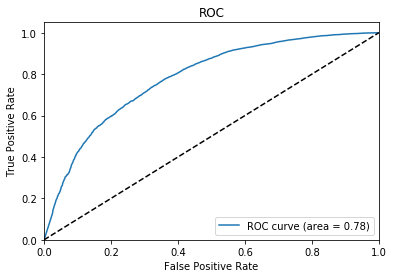

In [119]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()